# Diminishing fitness benefits with increasing cell type diversity can explain cell type allometry

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial
from scipy.optimize import curve_fit 
import pymc as pm
import arviz as az

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

### Definitions

In [155]:
def fitfun_power(N,off,slope_small,slope_large,Nbp):

    return [off + slope_small*n if n < Nbp 
            else off + slope_small*Nbp + slope_large*(n-Nbp)
            for n in N]

def fitfun_new(N,A,B):
    return np.log10(A + B*N)

def BIC(rss,n_dat,n_params):
    return n_dat*np.log(rss/n_dat) + n_params*np.log(n_dat)

def plot_model(dat,trace,ax,hdp_prob=95):
    
    mu_mean = trace.posterior['mu'].mean(axis=1).mean(axis=0)

    # plot mean
    ax.plot(x_dat,mu_mean,'-', color=mypalette[0],lw=3,label = 'mean regression curve')

    # plot hdi for mean (=regression curve)  
    sig = az.plot_hdi(x_dat, trace.posterior['mu'], hdi_prob=hdp_prob/100, 
                      fill_kwargs = {'label' : str(hdp_prob)+"% HDI of regression curve"},
                      color=mypalette[0],ax=ax)

    # plot hdi for ppd
    sigpp = az.plot_hdi(x_dat, trace.posterior_predictive['y'], 
                        fill_kwargs = {'label' : str(hdp_prob)+"% HDI of ppd"},
                        hdi_prob=hdp_prob/100, color=mypalette[1],ax=ax)

    # plot data
    ax.plot(np.log10(dat['N']),np.log10(dat['K']),'o',markersize=10,
             markeredgecolor='black',markerfacecolor='white',markeredgewidth=2,
             label = 'data from Fisher et al.')

    # az.plot_lm(idata=trace,x=x_dat,y='y',y_model='mu',kind_pp="hdi", kind_model="hdi")

    ax.set_ylim([-0.8,2.5])
    ax.set_xlabel('$log_{10}$(Number of cells)')
    ax.set_ylabel('$log_{10}$(Number of cell types)')


def get_post_mean(trace,param):
    return np.round(trace.posterior[param].mean().values,2)

def get_hdi(trace,param):
    return np.round(az.hdi(trace,hdi_prob=0.95),2)[param].values

mypalette = ['xkcd:royal blue','xkcd:tangerine']

### Load data

In [4]:
data = pd.read_excel('./curbio10341mmc2.xlsx')
dat = data.loc[:,['Total number of cells','Number of cell types']].dropna()
dat.columns = ['N','K']

# breakpoint reported by Fisher et al.
Nbp = np.log10(6.3e4)

/anaconda3/envs/SCALE_pymc/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Rough analysis with ordinary least squares fit 

/anaconda3/envs/SCALE_pymc/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


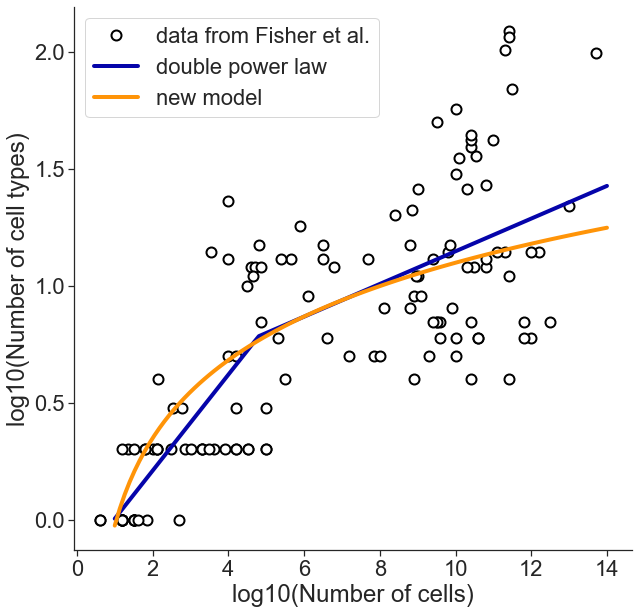

In [6]:
sns.set(font_scale=2,style="ticks")
fig,ax = plt.subplots(figsize=[10,10])


# plot data
plt.plot(np.log10(dat['N']),np.log10(dat['K']),'o',markersize=10,
         markeredgecolor='black',markerfacecolor='white',markeredgewidth=2)


# fit double power law 
fitfun = partial(fitfun_power,Nbp=Nbp)
fitparam_power,pcov = curve_fit(fitfun,np.log10(dat['N']),np.log10(dat['K']))

# obtain residual sum of squares for double power law
RSS_power = sum((np.log10(dat['K']) - fitfun_power(np.log10(dat['N']),*fitparam_power,Nbp=Nbp))**2)


# plot double power law
x = np.linspace(1,14,100)
y = fitfun_power(x,*fitparam_power,Nbp=Nbp)
l1 = ax.plot(x,y,'-',color=mypalette[0],linewidth=4);


# fit new model
fitparam_new,pcov = curve_fit(fitfun_new,np.log10(dat['N']),np.log10(dat['K']))

# obtain residual sum of squares for new model
RSS_new = sum((np.log10(dat['K']) - fitfun_new(np.log10(dat['N']),*fitparam_new))**2)

# # plot new model
x = np.linspace(1,14,100)
y = fitfun_new(x,*fitparam_new)
l2 = ax.plot(x,y,'-',color=mypalette[1],linewidth=4);

ax.set_xlabel('log10(Number of cells)')
ax.set_ylabel('log10(Number of cell types)')

ax.legend(['data from Fisher et al.','double power law','new model'])

sns.despine()


Residual sum of squares [RSS new model, RSS double power law]

In [7]:
np.round([RSS_new,RSS_power],2)

array([14.28, 13.22])

Bayesian information criterion [BIC new model, BIC double power law] 

In [8]:
np.round([BIC(RSS_new,dat.shape[0],2),BIC(RSS_power,dat.shape[0],3)],2)

array([-286.99, -292.41])

Double power law parameters [offset, slope_small, slope_large]

In [9]:
fitparam_power

array([-0.1998514 ,  0.20506008,  0.06980782])

New model parameters : [A,B]

In [10]:
fitparam_new

array([-0.34285462,  1.28871636])

# Bayesian hierarchical models

In [140]:
x_dat = np.log10(dat.sort_values(by='N')['N'])
y_dat = np.log10(dat.sort_values(by='N')['K'])

# number of tuning and sampling steps for Monte Carlo sampling
Ntune = 2000
Nsample = 10000

## Model definition and sampling

In [141]:
models = ['double power law, constant sd','double power law, variable sd',
         'new model, constant sd', 'new model, variable sd']

trace = dict()

### Double power law, constant sd 

double power law, constant sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope_small, breakpoint, slope_large, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 103 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


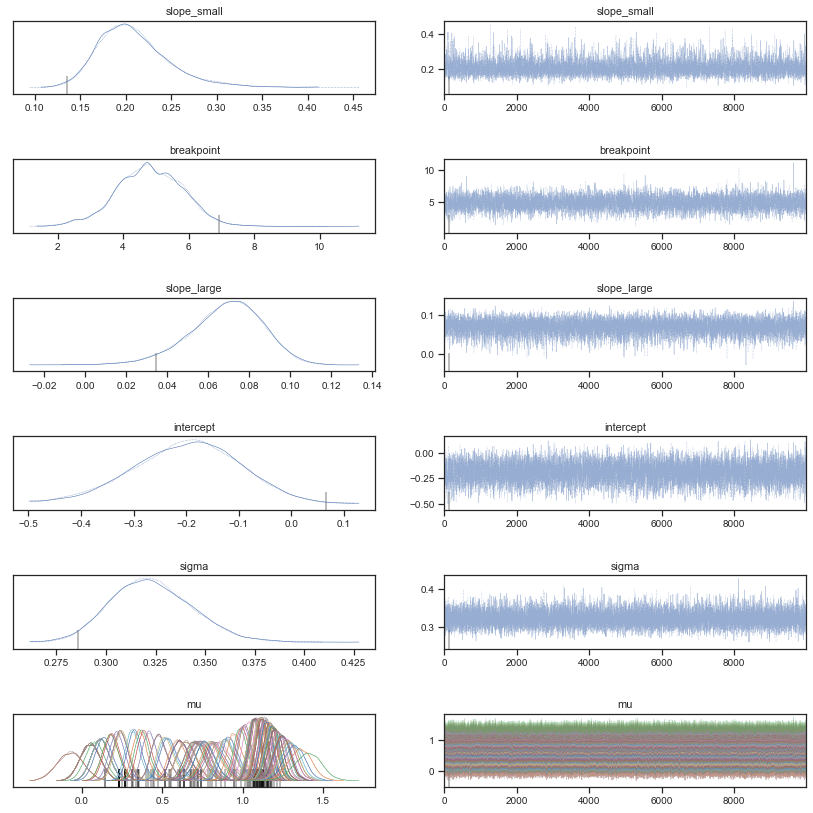

In [142]:
model = models[0]
print(model)

with pm.Model() as pm_model:

    # model definition
    intercept = pm.Uniform('intercept', lower=-0.5, upper=0.5, initval = 0.1)
    slope_small = pm.Normal('slope_small', mu=0, sigma=20)
    breakpoint = pm.Normal('breakpoint', mu=5, sigma=2, initval=5)
    slope_large = pm.Normal('slope_large', mu=0, sigma=20)

    part_1 = intercept + slope_small * x_dat
    part_2 = intercept + slope_small * breakpoint - slope_large * (breakpoint - x_dat)
    
    mu = pm.Deterministic('mu',pm.math.switch(breakpoint > x_dat,part_1,part_2))

    sigma = pm.HalfCauchy('sigma', beta=10, initval=1)
    
    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    # sampling
    trace[model] = pm.sample(Nsample,target_accept=0.8,tune=Ntune, progressbar=True)    
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True, random_seed=rng)
    
# check trace
az.plot_trace(trace[model])
plt.tight_layout()


### Double power law; sd depends on cell number

double power law, variable sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope_small, breakpoint, slope_large, sigma_intercept, sigma_slope]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 87 seconds.


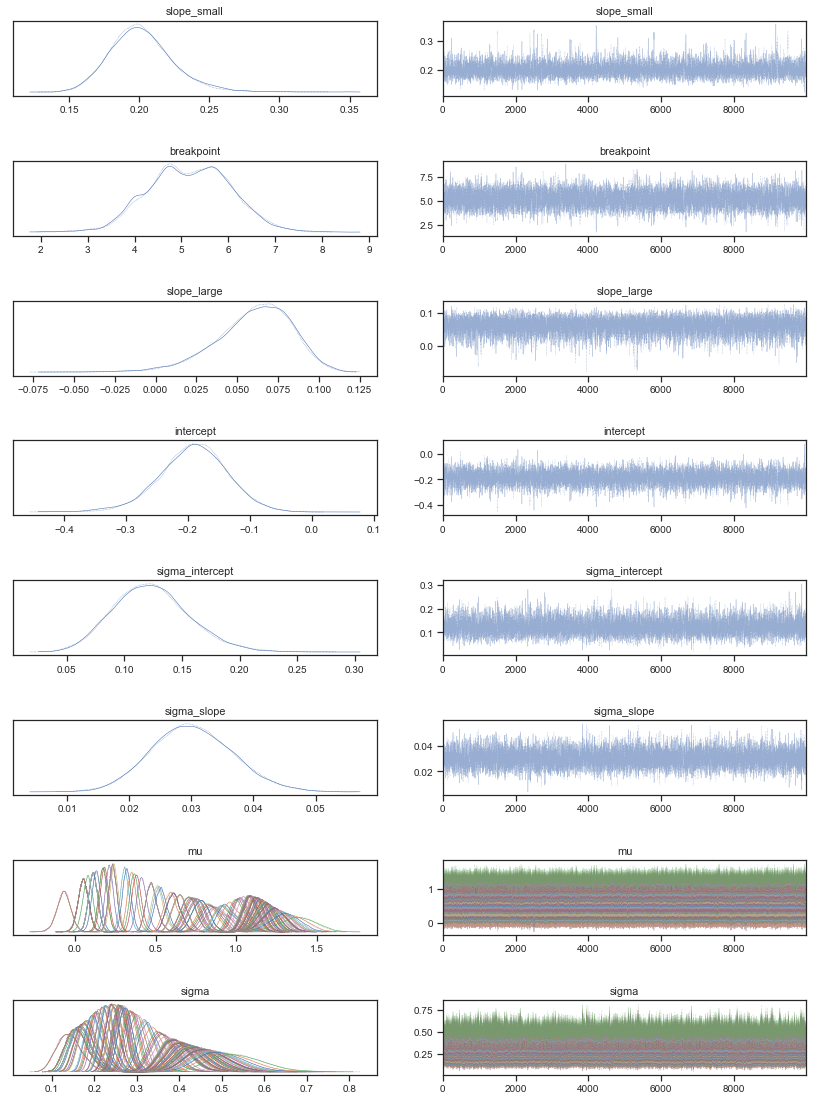

In [143]:
model = models[1]
print(model)

with pm.Model() as pm_model:

    # model definition
    intercept = pm.Uniform('intercept', lower=-0.5, upper=0.5, initval = 0.1)
    slope_small = pm.Normal('slope_small', mu=0, sigma=20)
    breakpoint = pm.Normal('breakpoint', mu=5, sigma=2, initval=5)
    slope_large = pm.Normal('slope_large', mu=0, sigma=20)

    part_1 = intercept + slope_small * x_dat
    part_2 = intercept + slope_small * breakpoint - slope_large * (breakpoint - x_dat)
    
    mu = pm.Deterministic('mu',pm.math.switch(breakpoint > x_dat,part_1,part_2))

    sigma_intercept = pm.HalfNormal('sigma_intercept',sigma=1,initval=0.3)
    sigma_slope = pm.HalfNormal('sigma_slope',sigma=1,initval=0.1)  
    sigma = pm.Deterministic('sigma',sigma_intercept + sigma_slope * x_dat) 
    
    # sampling
    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)
    trace[model] = pm.sample(Nsample,target_accept=0.8,tune=Ntune, progressbar=True)
    
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True, random_seed=rng)

# check trace
az.plot_trace(trace[model])
plt.tight_layout()

### New model, constant sd

new model, constant sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, B, sigma]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 47 seconds.


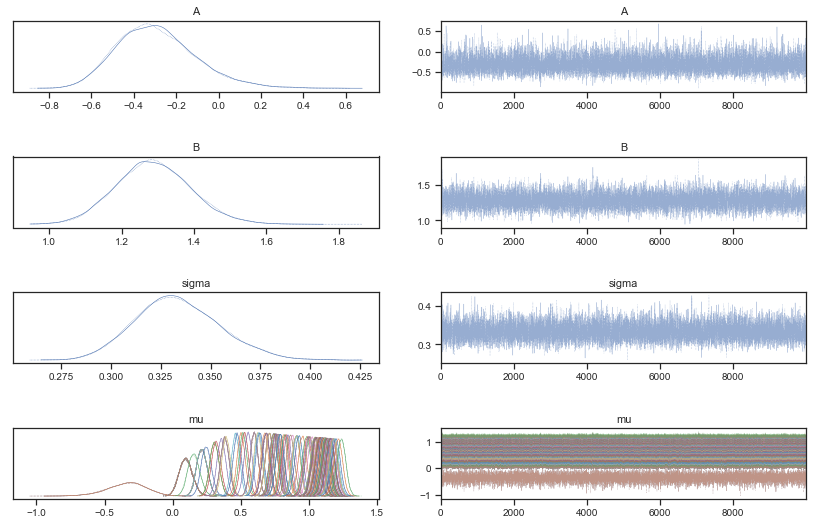

In [149]:
model = models[2]
print(model)

with pm.Model() as pm_model:
    
    #model definition
    A = pm.Normal('A', mu=0, sigma=20)
    B = pm.Normal('B', mu=0, sigma=20)
        
    mu = pm.Deterministic('mu',pm.math.log(A + B * x_dat)/pm.math.log(10))
    
    sigma = pm.HalfCauchy('sigma', beta=10, initval=1)

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    #sampling
    trace[model] = pm.sample(Nsample,target_accept=0.99,tune=Ntune, progressbar=True)    
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True, random_seed=rng)
    
# check trace
az.plot_trace(trace[model])
plt.tight_layout()

### New model, variable sd

new model, variable sd


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_intercept, sigma_slope, A, B]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 38 seconds.


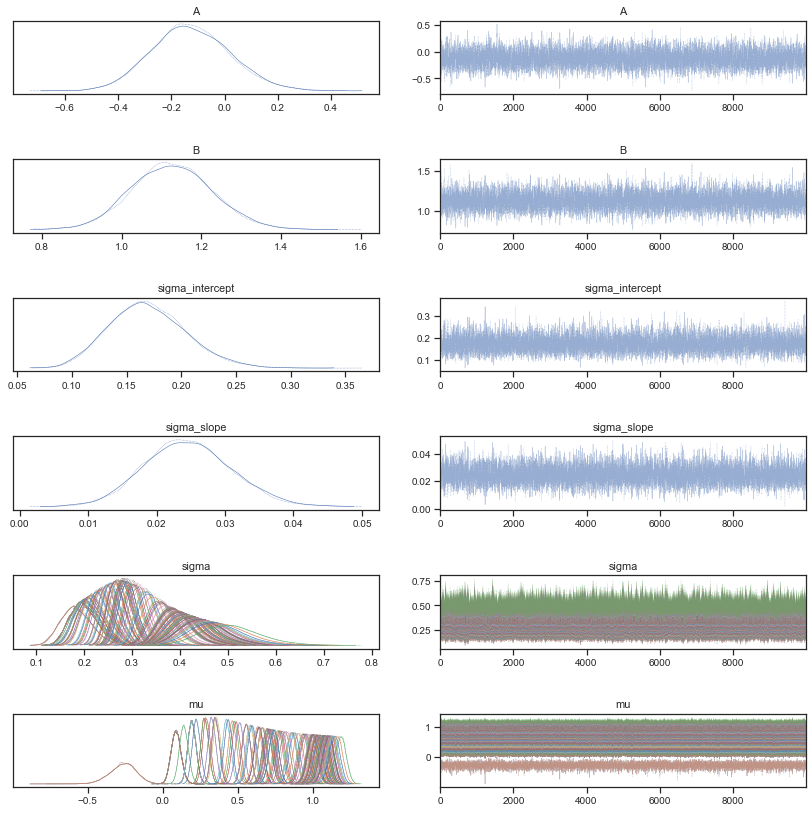

In [145]:
model = models[3]
print(model)

with pm.Model() as pm_model:
    
    #model definition
    sigma_intercept = pm.HalfNormal('sigma_intercept',sigma=1,initval=0.3)
    sigma_slope = pm.HalfNormal('sigma_slope',sigma=1,initval=0.1)    
    
    sigma = pm.Deterministic('sigma',sigma_intercept + sigma_slope * x_dat) 

    A = pm.Normal('A', mu=0, sigma=20)
    B = pm.Normal('B', mu=0, sigma=20)
        
    mu = pm.Deterministic('mu',pm.math.log(A + B * x_dat)/pm.math.log(10))

    likelihood = pm.Normal('y', mu=mu,sigma=sigma,observed=y_dat)

    # sampling
    trace[model] = pm.sample(Nsample,target_accept=0.8,tune=Ntune, progressbar=True)
    pm.sample_posterior_predictive(trace[model], extend_inferencedata=True, random_seed=rng)

#check trace
az.plot_trace(trace[model])
plt.tight_layout()

## Model comparison

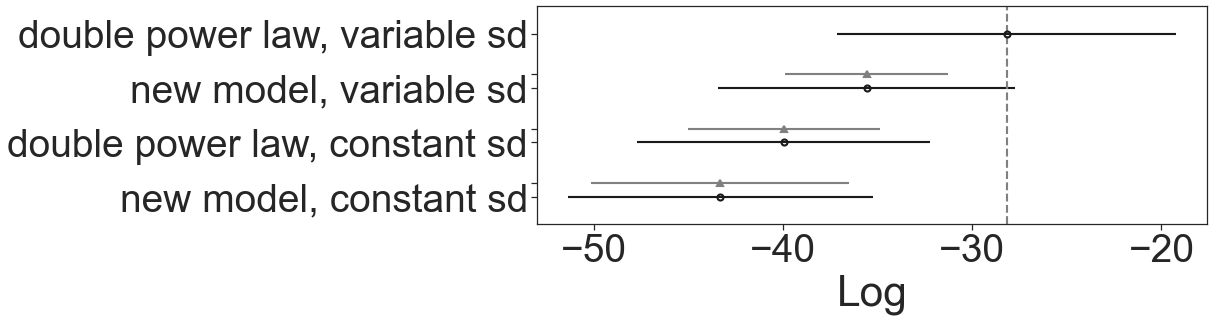

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
"double power law, variable sd",0,-28.183735,5.505763,0.000000,8.665867e-01,8.979618,0.000000,False,log
"new model, variable sd",1,-35.576633,3.837346,7.392898,5.996797e-14,7.832381,4.296790,False,log
"double power law, constant sd",2,-39.947452,4.313249,11.763717,6.889133e-14,7.736066,5.088843,False,log
"new model, constant sd",3,-43.312872,2.654735,15.129138,1.334133e-01,8.050624,6.816262,False,log


In [150]:
model_compare = az.compare(trace,ic='loo')
az.plot_compare(model_compare,insample_dev=False, figsize=(12, 4))
plt.show()

model_compare

### Plot results (Figure 1)

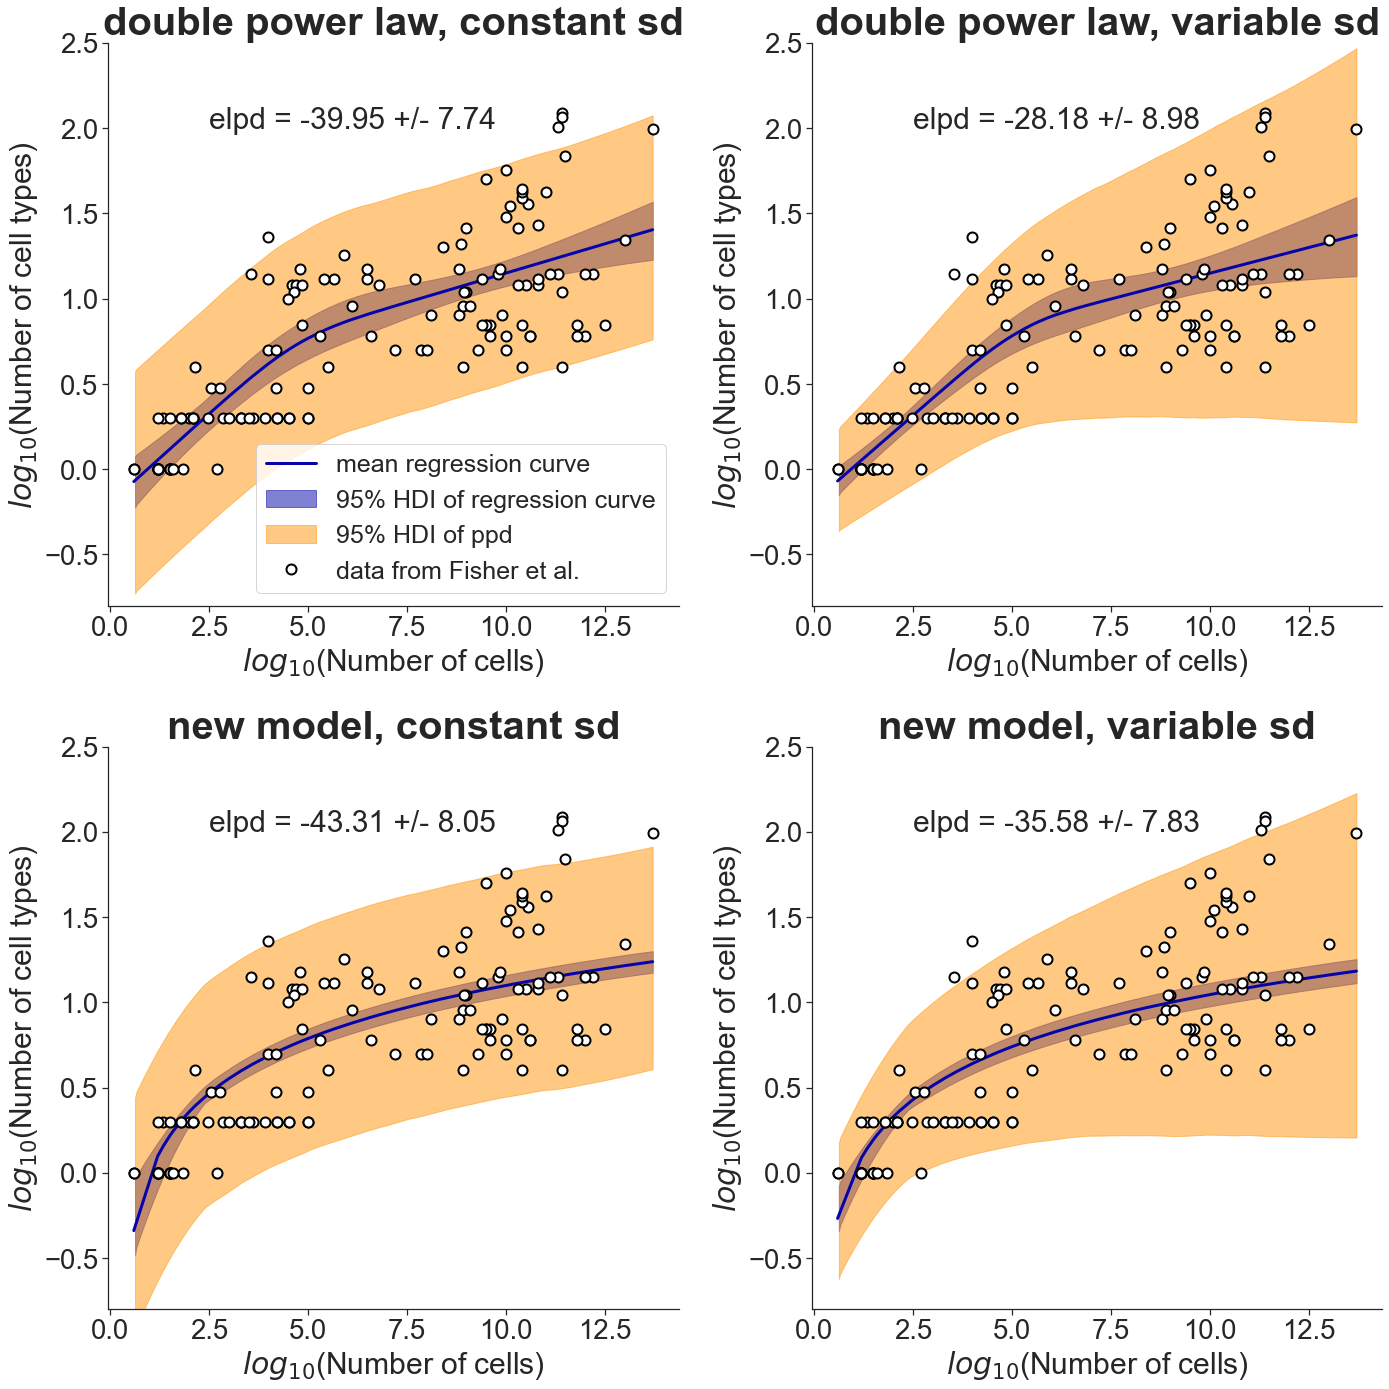

In [156]:
sns.set(font_scale=2.5,style="ticks")
fig,ax = plt.subplots(figsize=[20,20],ncols=2,nrows=2)

for count,model in enumerate(models):
    

    plot_model(dat,trace[model],np.ravel(ax)[count])
    np.ravel(ax)[count].set_title(model,fontsize=40,fontweight='bold')
    elpd = str(round(model_compare.loc[model,'loo'],2))
    elpd_se = str(round(model_compare.loc[model,'se'],2))
    np.ravel(ax)[count].text(2.5,2,'elpd = '+elpd+' +/- '+elpd_se,fontsize=30)
    
    if count ==0:
        np.ravel(ax)[count].legend(loc='lower right',fontsize=25)


sns.despine()
plt.tight_layout()
plt.savefig('fig1.png')


### Save parameter estimates and result of model comparison (Table 1)

In [154]:

columns = ['Fisher et al.'] + models

params = ['intercept','slope_small','breakpoint','slope_large','A','B',
          'sigma','sigma_intercept','sigma_slope']

index = params + ['elpd']

results = pd.DataFrame(columns = columns, index=index)

for model in models:
          
    for param in params:
        if param in [i for i in trace[model].posterior.data_vars]:
            if not ((param == 'sigma') & ('variable' in model)): 
                results.loc[param,model] = (str(get_post_mean(trace[model],param)) + ' ' 
                                            + str(get_hdi(trace[model],param)))

        results.loc['elpd',model] = (str(round(model_compare.loc[model,'loo'],2)) + ' [' 
                                    + str(round(model_compare.loc[model,'se'],2)) + ']')


results.loc['slope_small','Fisher et al.'] = '0.21 [0.16 0.26]'
results.loc['slope_large','Fisher et al.'] = '0.07 [0.03 0.11]'
results.loc['breakpoint','Fisher et al.'] = '4.8 [3.9 5.7]'

results = results.loc[:,['Fisher et al.','double power law, constant sd','new model, constant sd',
                 'double power law, variable sd','new model, variable sd']]
results.to_csv('table1.csv')
results

,Fisher et al.,"double power law, constant sd","new model, constant sd","double power law, variable sd","new model, variable sd"
intercept,NaN,-0.2 [-0.41 -0.01],NaN,-0.19 [-0.3 -0.08],NaN
slope_small,0.21 [0.16 0.26],0.21 [0.13 0.29],NaN,0.2 [0.16 0.25],NaN
breakpoint,4.8 [3.9 5.7],4.82 [2.85 6.8 ],NaN,5.18 [3.53 6.78],NaN
slope_large,0.07 [0.03 0.11],0.07 [0.03 0.1 ],NaN,0.06 [0.01 0.1 ],NaN
A,NaN,NaN,-0.29 [-0.63 0.1 ],NaN,-0.13 [-0.42 0.16]
B,NaN,NaN,1.29 [1.08 1.49],NaN,1.13 [0.93 1.32]
sigma,NaN,0.32 [0.29 0.36],0.33 [0.29 0.38],NaN,NaN
sigma_intercept,NaN,NaN,NaN,0.12 [0.06 0.19],0.17 [0.1 0.24]
sigma_slope,NaN,NaN,NaN,0.03 [0.02 0.04],0.02 [0.01 0.04]
elpd,NaN,-39.95 [7.74],-43.31 [8.05],-28.18 [8.98],-35.58 [7.83]
